# Main results
Here in the coming sections we will go through the main results which group 67 found while working on project 4: Velocity estimation from Doppler radar. The goal is simple, we want to beat the baseline model in test prediction RMSE while adhering to the following modelling constraint: We are not allowed to add model complexity (#parameters)

### Helper functions

In [12]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log10

from scipy import stats
from pathlib import Path
import torch
from torch import nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import json
import wandb

from custom_transforms import LoadSpectrogram, NormalizeSpectrogram, ToTensor, InterpolateSpectrogram
from data_management import make_dataset_name
from models import SpectrVelCNNRegr, SpectrVelCNNRegr_w_dropout, Simple_SpectrVelCNNRegr, SpectrVelCNNRegr_w_dropout_extra_CNN, weights_init_uniform_rule
from check_model_complexity import print_model_complexity
from plot_observation import plot_simple_spectrogram, plot_spectrogram_with_annotations


def load_single_spectrogram(file_path: str, transform) -> torch.Tensor:
    """
    Load and transform a single spectrogram for inference.
    
    Args:
        file_path (str): Path to the spectrogram file.
        transform (callable): Transform function to apply to the spectrogram.
        
    Returns:
        torch.Tensor: Transformed spectrogram ready for model inference.
    """
    # Load the spectrogram as a numpy array
    spectrogram = np.load(file_path)

    # Apply the transformations to the spectrogram
    spectrogram_tensor = transform(spectrogram)
    
    # Add batch dimension if necessary
    spectrogram_tensor = spectrogram_tensor.unsqueeze(0)  # shape: [1, C, H, W] for single sample
    
    return spectrogram_tensor

def run_inference(obs_no: int, MODEL_PATH: Path, model: nn.Module, DEVICE: str = "cpu", obs_type: str = "validation", dummy: int = 0) -> float:
    """
    Run inference on a given observation using a specified model.

    Args:
        obs_no (int): Observation number to load the spectrogram.
        MODEL_PATH (Path): Path to the trained model.
        model (nn.Module): The model to use for inference.
        DEVICE (str, optional): Device to run inference on (default is "cpu").

    Returns:
        float: Predicted radial velocity (vr).
    """
    # Define the transform for inference (use the same transformations as for training)
    infer_transform = transforms.Compose(
        [NormalizeSpectrogram(),
         ToTensor(),
         InterpolateSpectrogram()]
    )

    # Load the single spectrogram
    if dummy == 0:
        file_path = f"/dtu-compute/02456-p4-e24/data/data_fft-512_tscropwidth-150-200_vrcropwidth-60-15/{obs_type}/{obs_no}_stacked_spectrograms.npy"
    else:
        file_path = f"/zhome/52/6/202465/02456_grp_67_project_4/dummy_data/stacked_spectrogram_obs_{obs_no}.npy"

    spectrogram_tensor = load_single_spectrogram(file_path, infer_transform)

    # Move the tensor to the correct device
    spectrogram_tensor = spectrogram_tensor.to(DEVICE)

    # Load the model state dictionary with map_location set to the correct device
    model.load_state_dict(torch.load(MODEL_PATH, weights_only= False, map_location=torch.device(DEVICE)))
    model.to(DEVICE)
    model.eval()
    
    # Run inference and return the predicted vr
    with torch.no_grad():
        predicted_vr = model(spectrogram_tensor)
    
    return predicted_vr.item()

def extract_data(log_file_path):
    """
    Extracts data from the log file for epochs, batches, batch losses,
    training losses, and test losses.
    
    Parameters:
        log_file_path (str): Path to the log file.
    
    Returns:
        batch_df (pd.DataFrame): DataFrame containing batch losses with their epochs and batches.
        epoch_df (pd.DataFrame): DataFrame containing train and test losses for each epoch.
    """
    # Initialize lists to store extracted data
    epochs = []
    batches = []
    batch_losses = []
    train_losses = []
    test_losses = []

    with open(log_file_path, "r") as file:
        for line in file:
            # Match EPOCH lines to extract the epoch number
            epoch_match = re.match(r"EPOCH (\d+):", line)
            if epoch_match:
                current_epoch = int(epoch_match.group(1))
            
            # Match batch loss lines to extract batch number and loss
            batch_match = re.match(r"\s+batch (\d+) loss: ([\d.]+)", line)
            if batch_match:
                batch_num = int(batch_match.group(1))
                loss = float(batch_match.group(2))
                # Append each batch data with the current epoch number
                epochs.append(current_epoch)
                batches.append(batch_num)
                batch_losses.append(loss)
            
            # Match the final train and test loss per epoch
            train_loss_match = re.match(r"LOSS train ([\d.]+) ; LOSS test ([\d.]+)", line)
            if train_loss_match:
                train_losses.append(float(train_loss_match.group(1)))
                test_losses.append(float(train_loss_match.group(2)))

    # Create DataFrame for batch losses
    batch_df = pd.DataFrame({
        "Epoch": epochs,
        "Batch": batches,
        "Batch Loss": batch_losses
    })

    # Create DataFrame for epoch-wise train and test losses
    epoch_df = pd.DataFrame({
        "epoch": range(1, len(train_losses) + 1),
        "train_loss": train_losses,
        "test_loss": test_losses
    })

    return batch_df, epoch_df


def plot_losses(epoch_df, run_name_title='Baseline'):
    """
    Plots training and validation losses across epochs.

    Parameters:
        epoch_df (pd.DataFrame): DataFrame containing epoch, train_loss, and test_loss.
        run_name (str): Name of the run for labeling the plot.
    """

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_df['epoch'], epoch_df['train_loss'], label='Training Loss', color='blue')
    plt.plot(epoch_df['epoch'], epoch_df['test_loss'], label='Validation Loss', color='orange')

    # Customizing the plot
    plt.xscale('linear')
    plt.yscale('log')  # Log scale for the y-axis
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title(f'Training and validation for {run_name_title}')
    plt.legend(loc='upper right')
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    # Show the figure
    plt.show()

def perform_paired_ttest(test_loss_r1, test_loss_r2):
    """
    Perform a paired t-test between two sets of test predictions

    Parameters:
        test_predictions_m1 (list or array-like): Test predictions from the first model.
        test_predictions_m2 (list or array-like): Test predictions from the second model.

    Returns:
        dict: A dictionary containing the t-statistic, p-value, and a string interpretation of the result.
    """
    # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(test_loss_r1, test_loss_r2)

    # Interpretation
    significance = "statistically significant" if p_value < 0.05 else "not statistically significant"
    
    # Print results
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    print(f"The difference in test losses between the two runs is {significance}.")

    # Return results as a dictionary
    return {
        "t_statistic": t_stat,
        "p_value": p_value,
        "significance": significance
    }

def perform_wilcoxon_test(test_loss_r1, test_loss_r2):
    """
    Perform a Wilcoxon signed-rank test between two sets of test losses and interpret the results.

    Parameters:
        test_loss_r1 (list or array-like): Test losses from the first model/run.
        test_loss_r2 (list or array-like): Test losses from the second model/run.

    Returns:
        dict: A dictionary containing the test statistic, p-value, and a string interpretation of the result.
    """
    # Perform Wilcoxon signed-rank test
    wilcoxon_stat, p_value = stats.wilcoxon(test_loss_r1, test_loss_r2)

    # Interpretation
    significance = "statistically significant" if p_value < 0.05 else "not statistically significant"

    # Print results
    print(f"Wilcoxon test statistic: {wilcoxon_stat}")
    print(f"P-value: {p_value}")
    print(f"The difference in test losses between the two runs is {significance}.")

    # Return results as a dictionary
    return {
        "wilcoxon_statistic": wilcoxon_stat,
        "p_value": p_value,
        "significance": significance
    }

## The dataset
The dataset consists of spectrogram data and associated target radial velocity values for training and evaluation. It includes the following main components:

1. Spectrogram Data
- Observation Types: The dataset contains stacked spectrograms with 6 channels per observation and each spectrogram has dimensions height = 79 and width = 534.
- Channels:
    - Channels 1–4: Represent power spectrograms, capturing the intensity of signal frequencies over time.
    - Channels 5–6: Represent phase spectrograms, detailing the phase information of the signal.

- Observations:
    - Training set: 1,239 observations.
    - Test set: 743 observations.
    - Validation set: 83 observations.

2. Target Data
- Radial Velocity Values:
    - 258,368 valid radial velocity values are available.
    - 45,529 null (missing) radial velocity values are present, indicating incomplete data or observations where the target was not measurable.

In [11]:
# Path to the dataset JSON file
dataset_json_path = '/dtu-compute/02456-p4-e24/data/data_fft-512_tscropwidth-150-200_vrcropwidth-60-15/dataset.json' 

# Load and read the JSON data
with open(dataset_json_path, 'r') as f:
    dataset_info = json.load(f)

# Count the number of observations in each split
train_count = len(dataset_info.get('train', []))
test_count = len(dataset_info.get('test', []))
validation_count = len(dataset_info.get('validation', []))

# Print out the number of observations for each split
print(f"Train dataset observations: {train_count}")
print(f"Test dataset observations: {test_count}")
print(f"Validation dataset observations: {validation_count}")

Train dataset observations: 1239
Test dataset observations: 743
Validation dataset observations: 83


H x W x C = (79, 534, 6)


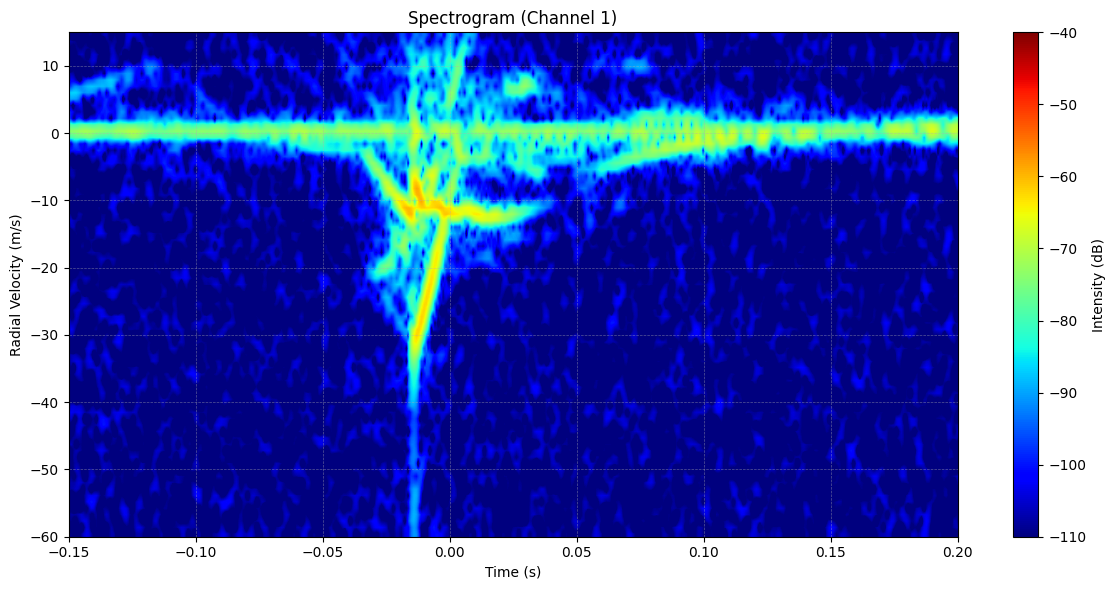

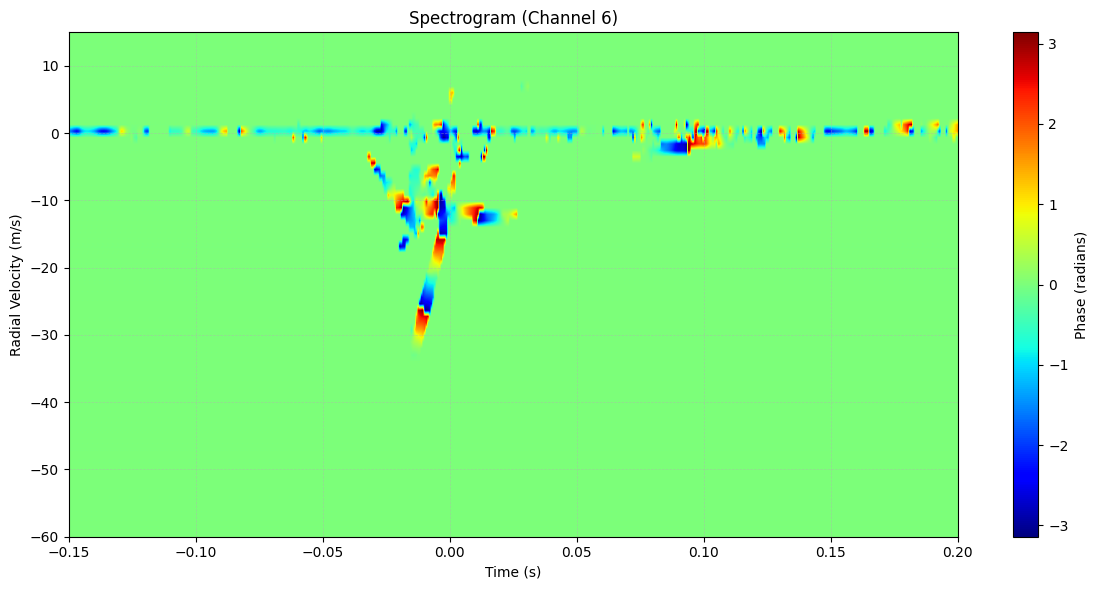

In [16]:
# Looking into spectograms of a random training observation
obs_no = 137026 
file_path = f"/dtu-compute/02456-p4-e24/data/data_fft-512_tscropwidth-150-200_vrcropwidth-60-15/train/{obs_no}_stacked_spectrograms.npy"
spectrogram = np.load(Path(file_path))
print(f'H x W x C = {np.shape(spectrogram)}')
plot_simple_spectrogram(file_path, spectrogram_channel=0) # Channesl 1-4 are power spectrograms
plot_simple_spectrogram(file_path, spectrogram_channel=5) # Channels 5-6 are phase spectrograms

## The Baseline Model

### Model architecture and complexity
We start with looking at the model architecture of the baseline model, called **SpectrVelCNNRegr**, and then check the model complexity, that is the total number of parameters in the model.

The SpectrVelCNNRegr model consists of four convolutional layers that progressively increase in depth, enabling it to first extract basic low-level features and then capture higher-level, abstract patterns in the deeper layers. After flattening the feature maps, the model uses two fully connected layers to learn complex relationships between these features, ultimately outputting a single value: the radial velocity. We also output the model settings which are learning rate = 1e-5, batch size = 10 and optimizer = SGD. Finally we look at the model complexity which is quite high, as the number of parameters is 38,414,929.

In [6]:
model = SpectrVelCNNRegr
learning_rate = 10**-5
batch_size = 10
optimizer = torch.optim.SGD

print(model())

# Print additional settings
print("\nModel Settings:")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Optimizer: {optimizer.__name__} \n")

print_model_complexity(model)
print("")

SpectrVelCNNRegr(
  (conv1): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=37120, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=256, bia

To visualize the training process, we plotted the loss curves for both the training and validation data, using a log scale to highlight the changes more effectively. We can clearly see the model is overfitting as the training loss consistently decreases but the validation loss plateaus early, failing to improve after a certain point. This was a strong suggestion that a good start was to add some regularization.

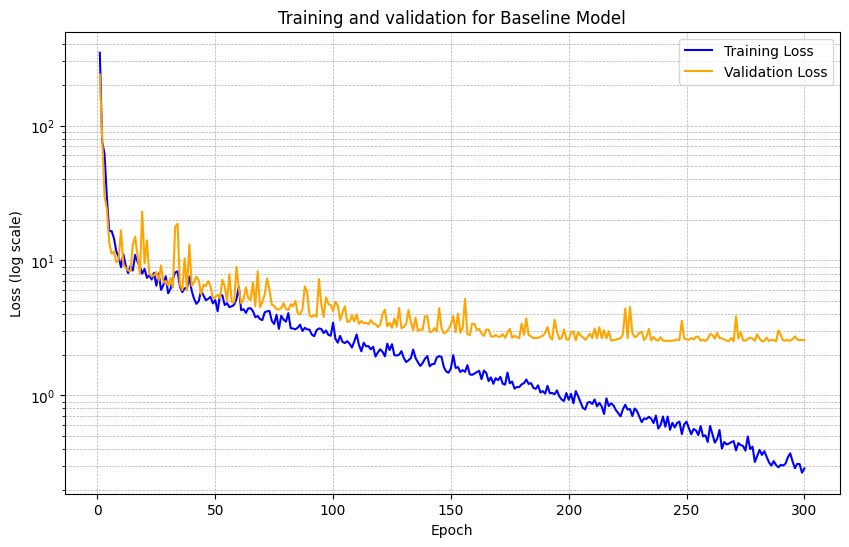

In [2]:
# Baseline training run:
run_name = 'baseline_run'
log_file_path = f"/zhome/52/6/202465/02456_grp_67_project_4/wandb/{run_name}/files/output.log"

# Extract data
batch_df, epoch_df = extract_data(log_file_path)

# Plot data
plot_losses(epoch_df, run_name_title='Baseline Model')

We then ran the model on the test set to get a final test prediction, as well as plotting the target and predicted radial velocity for a random observation. The baseline model has Test RMSE: 1.4859 m/s.

In [6]:
# Constants
MODEL = SpectrVelCNNRegr

DEVICE = "cpu"
MODEL_PATH = Path("/zhome/52/6/202465/02456_grp_67_project_4/models/model_SpectrVelCNNRegr_cerulean-galaxy-68")  # Path to the trained model

DATA_ROOT = Path(f"/dtu-compute/02456-p4-e24/data")
STM_FILENAME = "stmf_data_3.csv"
NFFT = 512
TS_CROPTWIDTH = (-150, 200)
VR_CROPTWIDTH = (-60, 15)

# Setting the dataset name
dataset_name = make_dataset_name(nfft=NFFT, ts_crop_width=TS_CROPTWIDTH, vr_crop_width=VR_CROPTWIDTH)
data_dir = DATA_ROOT / dataset_name

# Validation transform
VALIDATION_TRANSFORM = transforms.Compose(
    [LoadSpectrogram(root_dir=data_dir / "validation"),
     NormalizeSpectrogram(),
     ToTensor(),
     InterpolateSpectrogram()]
)

# Load validation dataset
dataset_validation = MODEL.dataset(
    data_dir=data_dir / "validation",
    stmf_data_path=DATA_ROOT / STM_FILENAME,
    transform=VALIDATION_TRANSFORM
)

# Load the validation dataset in batches
validation_data_loader = DataLoader(
    dataset_validation,
    batch_size=32,
    shuffle=False
)

# Load the trained model
model = MODEL().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True))
model.eval()  # Set to evaluation mode

# Initialize metrics and storage for predictions
total_loss = 0.0
total_samples = 0
baseline_predictions = []  # List to store model predictions

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    for batch in validation_data_loader:
        # Move batch data to the specified device
        spectrograms = batch["spectrogram"].to(DEVICE)
        targets = batch["target"].to(DEVICE)

        # Get model predictions
        outputs = model(spectrograms).squeeze()

        # Store the model predictions and corresponding targets
        baseline_predictions.extend(outputs.cpu().numpy())  # Convert to numpy array for easy handling

        # Calculate the loss for this batch using the model's loss function
        batch_loss = MODEL.loss_fn(outputs, targets)

        # Accumulate total loss scaled by the number of samples in the batch
        batch_size = len(targets)
        total_loss += batch_loss.item() * batch_size
        total_samples += batch_size

# Compute the average loss (MSE) over all samples
avg_loss = total_loss / total_samples

# Compute the RMSE by taking the square root of the average loss
avg_rmse = avg_loss**0.5

# Print the validation metrics
print(f"Test Loss: {avg_loss:.4f}, Test RMSE: {avg_rmse:.4f}")


Test Loss: 2.2079, Test RMSE: 1.4859


Target radial velocity for test observation 240552: -33.43795262
Predicted radial velocity for test observation 240552: -34.02035903930664


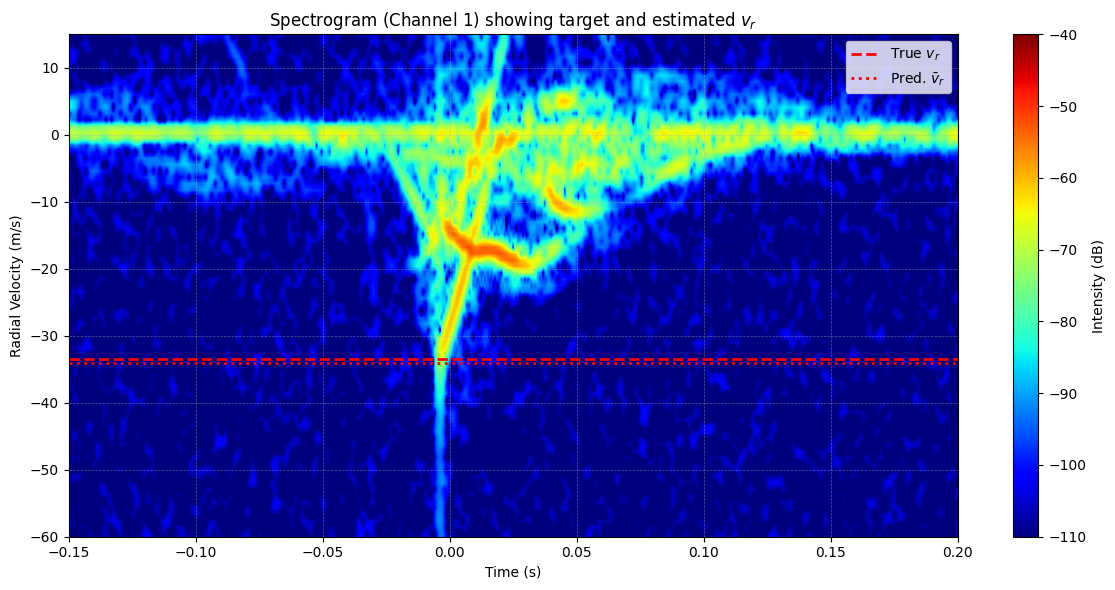

In [ ]:
MODEL_PATH = Path("/zhome/52/6/202465/02456_grp_67_project_4/models/model_SpectrVelCNNRegr_cerulean-galaxy-68") # Saved baseline model
model = SpectrVelCNNRegr() # The baseline model architect
DEVICE = "cpu"  

targets = pd.read_csv("/dtu-compute/02456-p4-e24/data/stmf_data_3.csv")
test_obs_no = 240552
test_target_vr = targets.BallVr.iloc[test_obs_no]

predicted_test_vr = run_inference(test_obs_no, MODEL_PATH, model, DEVICE, obs_type='validation')
print(f"Target radial velocity for test observation {test_obs_no}: {test_target_vr}")
print(f"Predicted radial velocity for test observation {test_obs_no}: {predicted_test_vr}")

file_path = f"/dtu-compute/02456-p4-e24/data/data_fft-512_tscropwidth-150-200_vrcropwidth-60-15/validation/{test_obs_no}_stacked_spectrograms.npy"
plot_spectrogram_with_annotations(file_path, target_vr=test_target_vr, estimated_vr=predicted_test_vr, spectrogram_channel=0)

## Improvements of the Baseline Model (keeping the same architecture)
To improve the baseline model's performance, especially on unseen data, we decided to incorporate regularization. However, before adding that, we started by changing the optimizer. Instead of using SGD (Stochastic Gradient Descent), we switched to the Adam optimizer, which generally performs well in a variety of scenarios. We also changed the learning rate from 1e-5 to 1e-4.

These changes resulted in the validation RMSE improving, dropping from 1.58 m/s to 1.29 m/s. Building on this, we experimented with different learning rates and batch sizes. Unfortunately, we couldn’t perform a thorough grid search due to the resource-intensive and time-consuming nature of the process. Instead our approach was to start simple and try different values for the learning rate. Having the learning configured as 1e-4 still gave the best result. Then we tried different values of the batch size (8, 16, 32, 64), and a batch size of 8 gave the best result so far in terms of validation RMSE.

Then we decided to add in dropout, starting with dropout=0.3. We added it to all layers which resulted in a more general model which did not perform as well. Since the purpouse of the CNN layers is to develop features that feed into the linear layers our next approach was to only add dropout to the linear layers. That further enhanced the performance. We then tried adding in L2 regularization (weight decay in the optimizer) but it didn't improve the model, and changing the dropout value did not either improve the model. Lastly we tried different batch size values, and now having a batch size of 16 resulted in the best model with a test RMSE of 1.0824 m/s.

In [7]:
model = SpectrVelCNNRegr_w_dropout
learning_rate = 1e-4
batch_size = 16
optimizer = torch.optim.Adam

print(model())

# Print additional settings
print("\nModel Settings:")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Optimizer: {optimizer.__name__} \n")

print_model_complexity(model)
print("")

SpectrVelCNNRegr_w_dropout(
  (conv1): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Sequential(
    (0): Linear(in_features=37120, out_features=1024, bias=True)
    (1): Dropout(p=0.3, inpl

In [8]:
# Constants
MODEL = SpectrVelCNNRegr_w_dropout

DEVICE = "cpu"
MODEL_PATH = Path("/zhome/52/6/202465/02456_grp_67_project_4/models/model_SpectrVelCNNRegr_w_dropout_dainty-vortex-38")  # Path to the trained model

DATA_ROOT = Path(f"/dtu-compute/02456-p4-e24/data")
STM_FILENAME = "stmf_data_3.csv"
NFFT = 512
TS_CROPTWIDTH = (-150, 200)
VR_CROPTWIDTH = (-60, 15)

# Setting the dataset name
dataset_name = make_dataset_name(nfft=NFFT, ts_crop_width=TS_CROPTWIDTH, vr_crop_width=VR_CROPTWIDTH)
data_dir = DATA_ROOT / dataset_name

# Validation transform
VALIDATION_TRANSFORM = transforms.Compose(
    [LoadSpectrogram(root_dir=data_dir / "validation"),
     NormalizeSpectrogram(),
     ToTensor(),
     InterpolateSpectrogram()]
)

# Load validation dataset
dataset_validation = MODEL.dataset(
    data_dir=data_dir / "validation",
    stmf_data_path=DATA_ROOT / STM_FILENAME,
    transform=VALIDATION_TRANSFORM
)

# Load the validation dataset in batches
validation_data_loader = DataLoader(
    dataset_validation,
    batch_size=32,  # Process in smaller batches for scalability
    shuffle=False
)

# Load the trained model
model = MODEL().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True))
model.eval()  # Set to evaluation mode

# Initialize metrics
total_loss = 0.0
total_samples = 0
m1_predictions = []  # List to store model predictions

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    for batch in validation_data_loader:
        # Move batch data to the specified device
        spectrograms = batch["spectrogram"].to(DEVICE)
        targets = batch["target"].to(DEVICE)

        # Get model predictions
        outputs = model(spectrograms).squeeze()

        # Store the model predictions and corresponding targets
        m1_predictions.extend(outputs.cpu().numpy())  # Convert to numpy array for easy handling

        # Calculate the loss for this batch using the model's loss function
        batch_loss = MODEL.loss_fn(outputs, targets)

        # Accumulate total loss scaled by the number of samples in the batch
        batch_size = len(targets)
        total_loss += batch_loss.item() * batch_size
        total_samples += batch_size

# Compute the average loss (MSE) over all samples
avg_loss = total_loss / total_samples

# Compute the RMSE by taking the square root of the average loss
avg_rmse = avg_loss**0.5

# Print the validation metrics
print(f"Test Loss: {avg_loss:.4f}, Test RMSE: {avg_rmse:.4f}")

Test Loss: 1.1716, Test RMSE: 1.0824


## A more simple model

Finally, we wanted to try and make a more simple model, with regards to the total number of model parameters. We started out from our current best model but now with trying different things such as removing layers, reducing the number of hidden units in the linear layer and the CNN layers, but it didn't improve the current best model. Until we tried adding in a CNN layer, with hyperparameter tuning, we ended up with a model that had fewer total model parameters (24,292,177) and test RMSE of 1.0389 m/s.


In [9]:
model = SpectrVelCNNRegr_w_dropout_extra_CNN
learning_rate = 1e-4
batch_size = 16
optimizer = torch.optim.Adam

print(model())

# Print additional settings
print("\nModel Settings:")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Optimizer: {optimizer.__name__} \n")

print_model_complexity(model)
print("")

SpectrVelCNNRegr_w_dropout_extra_CNN(
  (conv1): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Sequential(
    (0): Linear(in_features=23040, out_features=1024, bias=True)
    (1): Dropout(p

In [10]:
# Constants
MODEL = SpectrVelCNNRegr_w_dropout_extra_CNN

DEVICE = "cpu"
MODEL_PATH = Path("/zhome/52/6/202465/02456_grp_67_project_4/models/extra_CNN_model")  # Path to the trained model

DATA_ROOT = Path(f"/dtu-compute/02456-p4-e24/data")
STM_FILENAME = "stmf_data_3.csv"
NFFT = 512
TS_CROPTWIDTH = (-150, 200)
VR_CROPTWIDTH = (-60, 15)

# Setting the dataset name
dataset_name = make_dataset_name(nfft=NFFT, ts_crop_width=TS_CROPTWIDTH, vr_crop_width=VR_CROPTWIDTH)
data_dir = DATA_ROOT / dataset_name

# Validation transform
VALIDATION_TRANSFORM = transforms.Compose(
    [LoadSpectrogram(root_dir=data_dir / "validation"),
     NormalizeSpectrogram(),
     ToTensor(),
     InterpolateSpectrogram()]
)

# Load validation dataset
dataset_validation = MODEL.dataset(
    data_dir=data_dir / "validation",
    stmf_data_path=DATA_ROOT / STM_FILENAME,
    transform=VALIDATION_TRANSFORM
)

# Load the validation dataset in batches
validation_data_loader = DataLoader(
    dataset_validation,
    batch_size=32,  # Process in smaller batches for scalability
    shuffle=False
)

# Load the trained model
model = MODEL().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True))
model.eval()  # Set to evaluation mode

# Initialize metrics
total_loss = 0.0
total_samples = 0
m2_predictions = []  # List to store model predictions

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    for batch in validation_data_loader:
        # Move batch data to the specified device
        spectrograms = batch["spectrogram"].to(DEVICE)
        targets = batch["target"].to(DEVICE)

        # Get model predictions
        outputs = model(spectrograms).squeeze()

        # Store the model predictions and corresponding targets
        m2_predictions.extend(outputs.cpu().numpy())  # Convert to numpy array for easy handling

        # Calculate the loss for this batch using the model's loss function
        batch_loss = MODEL.loss_fn(outputs, targets)

        # Accumulate total loss scaled by the number of samples in the batch
        batch_size = len(targets)
        total_loss += batch_loss.item() * batch_size
        total_samples += batch_size

# Compute the average loss (MSE) over all samples
avg_loss = total_loss / total_samples

# Compute the RMSE by taking the square root of the average loss
avg_rmse = avg_loss**0.5

# Print the validation metrics
print(f"Test Loss: {avg_loss:.4f}, Test RMSE: {avg_rmse:.4f}")

Test Loss: 1.0793, Test RMSE: 1.0389


And the visualization of the target radial velocity against the predicion plotted on to the spectrogram.

Target radial velocity for test observation 240552: -33.43795262
Predicted radial velocity for test observation 240552: -33.75067901611328


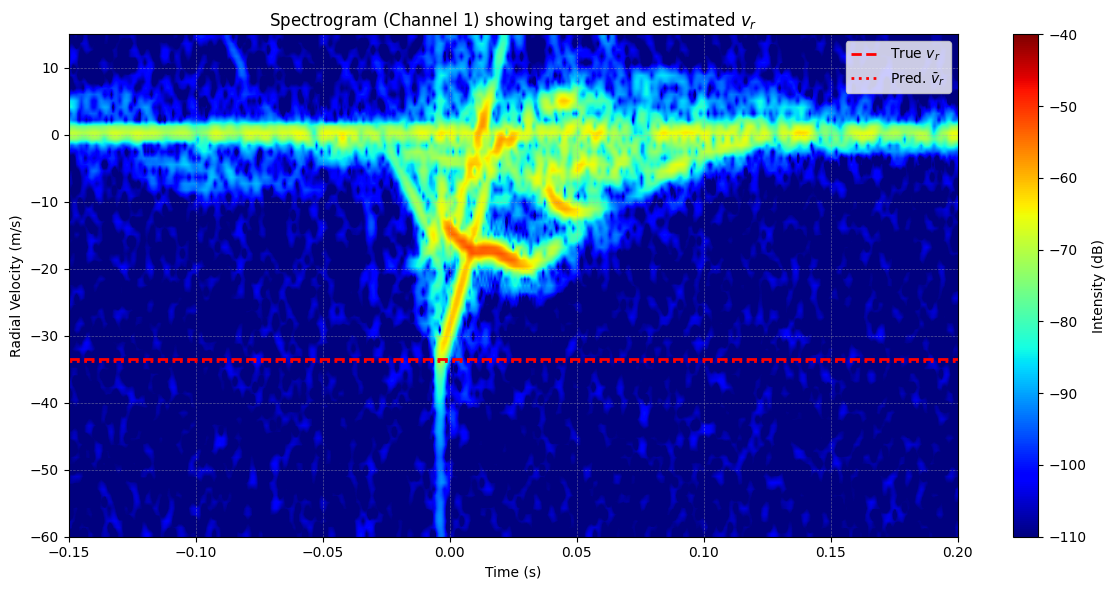

In [5]:
MODEL_PATH = Path("/zhome/52/6/202465/02456_grp_67_project_4/models/extra_CNN_model") # Saved baseline model
model = SpectrVelCNNRegr_w_dropout_extra_CNN() # The baseline model architect
DEVICE = "cpu"  

targets = pd.read_csv("/dtu-compute/02456-p4-e24/data/stmf_data_3.csv")
test_obs_no = 240552
test_target_vr = targets.BallVr.iloc[test_obs_no]

predicted_test_vr = run_inference(test_obs_no, MODEL_PATH, model, DEVICE, obs_type='validation')
print(f"Target radial velocity for test observation {test_obs_no}: {test_target_vr}")
print(f"Predicted radial velocity for test observation {test_obs_no}: {predicted_test_vr}")

file_path = f"/dtu-compute/02456-p4-e24/data/data_fft-512_tscropwidth-150-200_vrcropwidth-60-15/validation/{test_obs_no}_stacked_spectrograms.npy"
plot_spectrogram_with_annotations(file_path, target_vr=test_target_vr, estimated_vr=predicted_test_vr, spectrogram_channel=0)

## Statistical paired t-test
Statistical t-tests that compares the mean of the prediction distributions of the baseline against our two models, to see if there is statistically significant difference. We start of with doing it for the first model (which we call for simplicity model 1):


T-statistic: 0.5659265609019207
P-value: 0.5729891815834931
The difference in test losses between the two runs is not statistically significant.


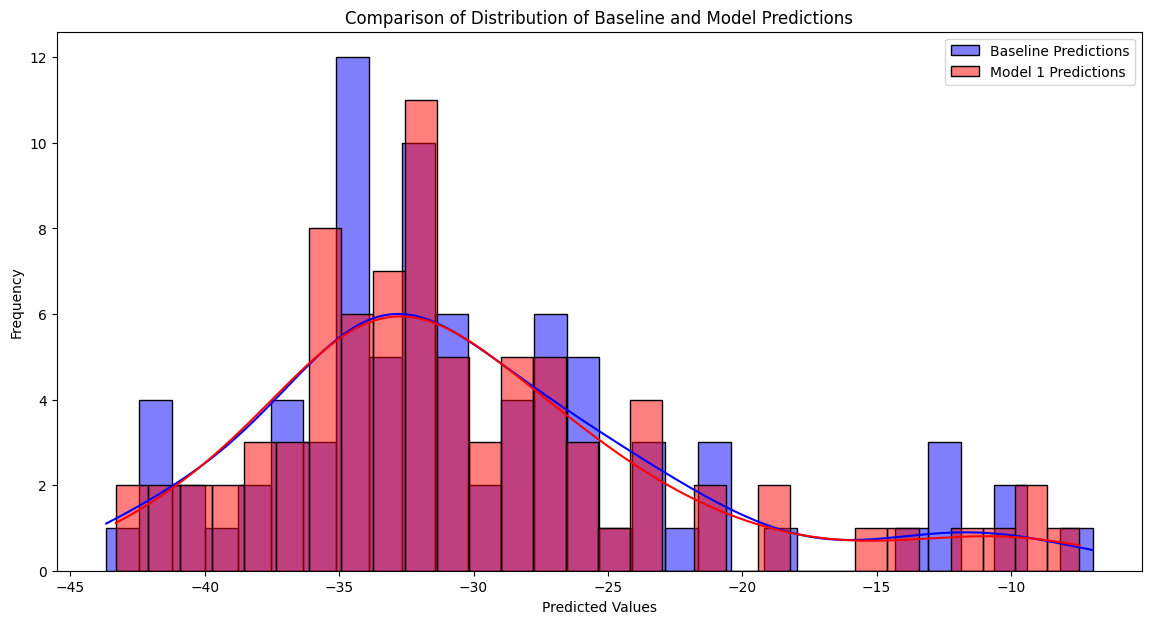

In [13]:
baseline_predictions = [float(x) for x in baseline_predictions]
model_predictions = [float(x) for x in m1_predictions]

t_test_results = perform_paired_ttest(baseline_predictions, model_predictions)

# Set up the plot with seaborn for better aesthetics
plt.figure(figsize=(14, 7))

# Plot baseline predictions
sns.histplot(baseline_predictions, bins=30, kde=True, color='blue', label='Baseline Predictions', alpha=0.5)

# Plot model predictions
sns.histplot(model_predictions, bins=30, kde=True, color='red', label='Model 1 Predictions', alpha=0.5)

# Add labels and title
plt.title("Comparison of Distribution of Baseline and Model Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Frequency")

# Add a legend to differentiate between the two plots
plt.legend()

# Display the plot
plt.show()


And then for the second model, with the added CNN layer:

T-statistic: -0.16529760899931545
P-value: 0.8691165786526517
The difference in test losses between the two runs is not statistically significant.


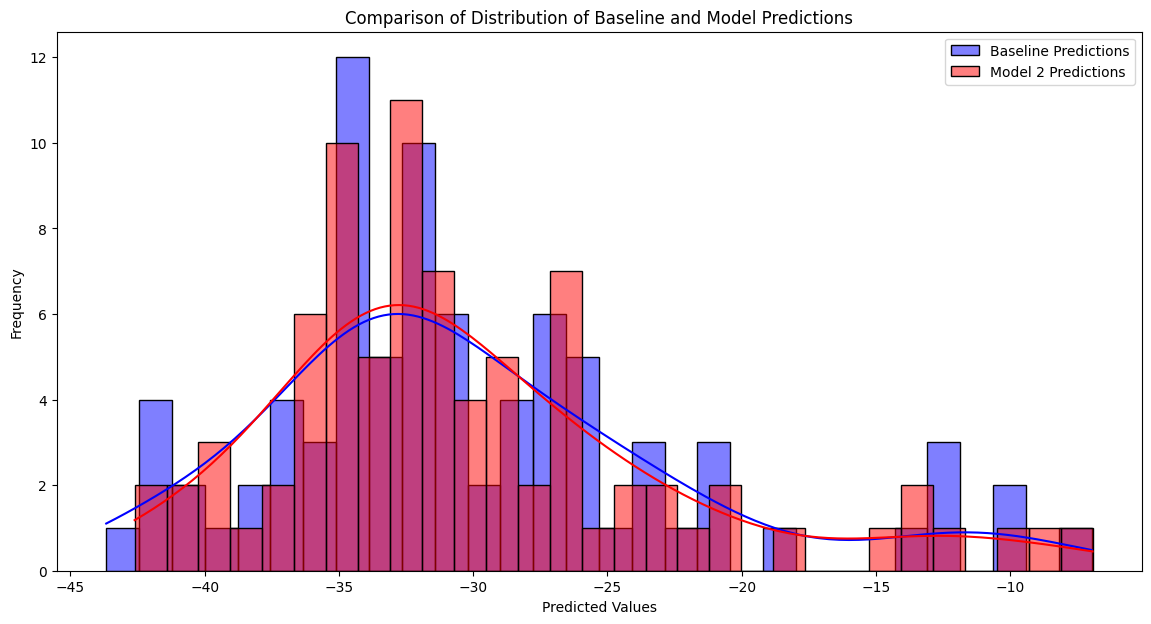

In [15]:
baseline_predictions = [float(x) for x in baseline_predictions]
model_predictions = [float(x) for x in m2_predictions]

t_test_results = perform_paired_ttest(baseline_predictions, model_predictions)

# Set up the plot with seaborn for better aesthetics
plt.figure(figsize=(14, 7))

# Plot baseline predictions
sns.histplot(baseline_predictions, bins=30, kde=True, color='blue', label='Baseline Predictions', alpha=0.5)

# Plot model predictions
sns.histplot(model_predictions, bins=30, kde=True, color='red', label='Model 2 Predictions', alpha=0.5)

# Add labels and title
plt.title("Comparison of Distribution of Baseline and Model Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Frequency")

# Add a legend to differentiate between the two plots
plt.legend()

# Display the plot
plt.show()


The results from the test indicate that there is not statistical difference between the baseline and our two models.

## Dummy data

As the data we trained our models on is not shareable we created some synthetic stacked spectrograms along with some target radial velocity values, as the project submission requires data. We created three different stacked spectrograms with 6 channels where channels 1-4 are power spectrograms and channels 5-6 are phase spectrograms. Applying model 2 to them yields in the following results:

Target radial velocity for dummy observation 1: -29.485839
Predicted radial velocity for dummy observation 1: -21.249563217163086


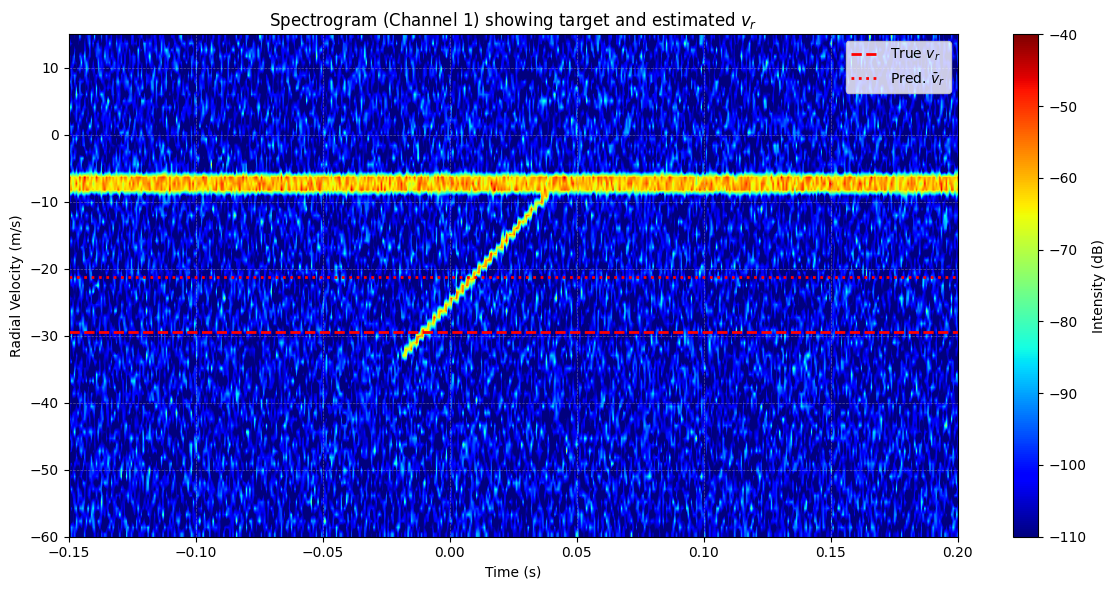

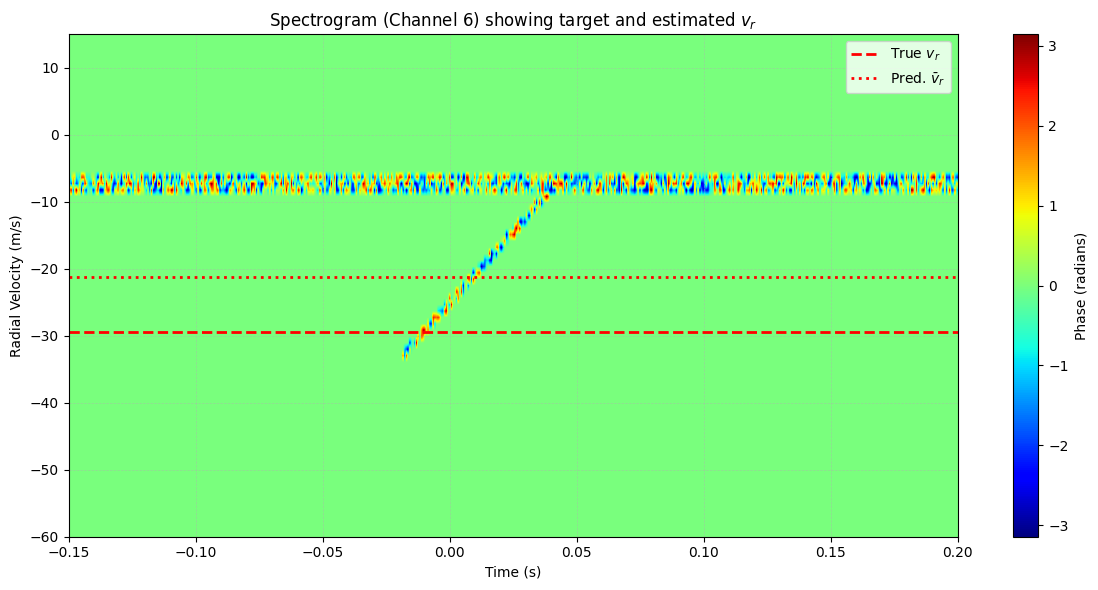

In [17]:
MODEL_PATH = Path("/zhome/52/6/202465/02456_grp_67_project_4/models/extra_CNN_model")
model = SpectrVelCNNRegr_w_dropout_extra_CNN()
DEVICE = "cpu"  

obs_no = 1
targets = pd.read_csv("/zhome/52/6/202465/02456_grp_67_project_4/dummy_data/dummy_target_vr.csv")
target_vr = targets.iloc[obs_no]['BallVr']

predicted_vr = run_inference(obs_no, MODEL_PATH, model, DEVICE, dummy=1)
print(f"Target radial velocity for dummy observation {obs_no}: {target_vr}")
print(f"Predicted radial velocity for dummy observation {obs_no}: {predicted_vr}")

file_path = f"/zhome/52/6/202465/02456_grp_67_project_4/dummy_data/stacked_spectrogram_obs_{1}.npy"
plot_spectrogram_with_annotations(file_path, target_vr=target_vr, estimated_vr=predicted_vr, spectrogram_channel=0)
plot_spectrogram_with_annotations(file_path, target_vr=target_vr, estimated_vr=predicted_vr, spectrogram_channel=5)